# **Trabajo Práctico N°2 - Aprendizaje Automático 1**
**Integrantes**:

Dito, Daniela

Flaibani, Marcela

López Crespo, facundo

## Librerías

In [199]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


## 1. Análisis descriptivo 

In [200]:
df = pd.read_csv('weatherAUS.csv')
df.shape

(145460, 23)

In [201]:
# Elección aleatoria de 10 ciudades
ciud = pd.Series(df['Location'].unique())
ciud_10 = ciud.sample(n=10,random_state=1)
ciud_10

27        Dartmoor
34       Nuriootpa
39    PerthAirport
48           Uluru
2            Cobar
3     CoffsHarbour
42         Walpole
29          Cairns
45    AliceSprings
30       GoldCoast
dtype: object

In [202]:
# Filtro del df según ciudades seleccionadas y luego descarto la columna ciudad 
df_weather = df[df['Location'].isin(ciud_10)]
df_weather = df_weather.drop('Location',axis=1)

In [203]:
df_weather.columns

Index(['Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow'],
      dtype='object')

El dataset a analizar se compone de observaciones diarias de las siguientes variables meteorológicas:
* **Temperatura**: [MinTemp, MaxTemp, Temp9am, Temp3pm]. Variables cuantitativas continuas. 

* **Lluvia**: 

    [Rainfall]. Variable cuantitavia continua.

    [RainToday, RainTomorrow]. Variable cualitativa nominal.
* **Evaporización**: [Evaporation]. Variable cuantitavia .

* **Luminosidad**: [Sunshine]. Variable cuantitativa. 
* **Viento**: 

    [WindSpeed9am, WindSpeed3pm, WindGustSpeed]. Variables cuantitativas continuas.

    [WindGustDir, WindDir9am, WindDir3pm]. Variables cualitativas nominales
* **Humedad**: [Humidity9am, Humidity3pm]. Variables cuantitativas continuas. 

* **Presión**: [Pressure9am, Pressure3pm]. Variables cuantitativas continuas.  
* **Nubosidad**: [Cloud9am, Cloud3pm]. Variables cuantitativas continuas.  


In [204]:
# Elimino las observaciones cuya variable target tiene valor nulo
df_weather = df_weather.dropna(subset=['RainTomorrow'])

In [230]:
# En relación al tiempo se utilizan las features Date(cuantitativa) y Month(cualitativa)
df_weather['Date']=pd.to_datetime(df_weather['Date'],format='mixed')
df_weather['Month'] = df_weather['Date'].dt.month
meses = ['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic']
month_dict = {}
for i,mes in enumerate(meses):
    month_dict[i+1] = mes
df_weather['Month'] = df_weather['Month'].map(month_dict)    

In [232]:
# Reducción de la cantidad de categorías correspondientes con la dirección del viento. De 16 a 4.
direccion_viento_dict = {
    'SSW':'S',
    'S':'S',
    'SE':'S',
    'NNE':'N',
    'WNW':'W',
    'N':'N',
    'ENE':'E',
    'NE':'N',
    'E':'E',
    'SW':'S',
    'W':'W',
    'WSW':'W',
    'NNW':'N',
    'ESE':'E',
    'SSE':'S',
    'NW':'N'
}
df_weather[['WindGustDir', 'WindDir9am', 'WindDir3pm']] = df_weather[['WindGustDir', 'WindDir9am', 'WindDir3pm']].map(direccion_viento_dict)


TypeError: the first argument must be callable

In [ ]:
df_weather.info()

In [206]:
df_weather.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Month
6049,2009-01-01,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,SW,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,ene
6050,2009-01-02,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,SSE,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,ene
6051,2009-01-03,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,N,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,ene
6052,2009-01-04,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,NNW,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,ene
6053,2009-01-05,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,WSW,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,ene


In [207]:
# División del DF entre train y test VER STRATIFY
X = df_weather.drop(columns='RainTomorrow')
y = df_weather['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22587, 22), (5647, 22), (22587,), (5647,))

In [208]:
#Armo los data frame de entrenamiento y de testeo
df_train = pd.concat([X_train,y_train],axis=1)
df_test = pd.concat([y_test,y_test],axis=1)

In [209]:
# Filtro aquellos registros de entrenamiento que no tienen más de 3 features nulas 
# es lo que permite el límite del 5% para eliminar registros del conjunto de entrenamiento
idxs_registros_aceptables = df_train.dropna(thresh=18).index
X_train = X_train.loc[idxs_registros_aceptables]
y_train = y_train.loc[idxs_registros_aceptables]
X_train.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)

In [210]:
# Solamente se describen variables cuantitativas
round(X_train.describe(),1)

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,22047,22027.0,22034.0,22023.0,14629.0,12389.0,21881.0,22033.0,22036.0,21847.0,21847.0,22025.0,22031.0,13201.0,12817.0,22044.0,22046.0
mean,2013-04-25 05:29:54.366580480,13.6,25.0,2.6,5.8,8.0,40.1,15.3,19.5,63.6,49.4,1017.5,1014.9,3.9,4.0,19.0,23.5
min,2008-12-01 00:00:00,-5.2,7.0,0.0,0.0,0.0,9.0,0.0,0.0,1.0,1.0,982.0,985.1,0.0,0.0,-0.3,5.3
25%,2011-02-08 12:00:00,8.7,19.8,0.0,2.8,5.3,31.0,9.0,13.0,50.0,30.0,1013.0,1010.3,1.0,1.0,13.9,18.4
50%,2013-06-18 00:00:00,13.4,24.9,0.0,5.0,9.0,39.0,15.0,19.0,65.0,52.0,1017.4,1014.8,4.0,4.0,19.0,23.2
75%,2015-06-28 00:00:00,18.8,29.9,0.6,8.0,10.9,48.0,20.0,24.0,80.0,66.0,1021.9,1019.3,7.0,7.0,24.2,28.1
max,2017-06-25 00:00:00,31.0,46.6,371.0,86.2,14.3,113.0,72.0,61.0,100.0,100.0,1040.4,1037.7,8.0,8.0,39.4,45.2
std,NaN,6.4,7.0,10.3,4.3,3.7,11.9,8.2,8.1,22.1,23.1,6.6,6.6,2.9,2.8,6.6,6.8


In [211]:
# Obtengo el porcentaje de valores faltantes por feature
round(X_train.isna().sum().sort_values(ascending=False) / len(X_train) * 100, 0) 

Sunshine         44.0
Cloud3pm         42.0
Cloud9am         40.0
Evaporation      34.0
WindDir9am        4.0
Humidity9am       1.0
Humidity3pm       1.0
WindGustDir       1.0
WindGustSpeed     1.0
WindDir3pm        0.0
Rainfall          0.0
RainToday         0.0
Pressure9am       0.0
MinTemp           0.0
Pressure3pm       0.0
WindSpeed9am      0.0
MaxTemp           0.0
WindSpeed3pm      0.0
Temp9am           0.0
Temp3pm           0.0
Date              0.0
Month             0.0
dtype: float64

In [212]:
# Interesa distinguir las features cuantitativas de aquellas features cualitativas
features_cuanti = list(X_train.describe().columns)
features_cuali = [feature for feature in X_train.columns if feature not in features_cuanti]
print(f'Features cuantitativas:\n')
[print(feature_cuanti) for feature_cuanti in features_cuanti]
print(f'Features cualitativas:\n')
[print(feature_cuali) for feature_cuali in features_cuali]
# Elimino feature date de cuanti para que después no traiga problemas
features_cuanti.remove('Date')

Features cuantitativas:

Date
MinTemp
MaxTemp
Rainfall
Evaporation
Sunshine
WindGustSpeed
WindSpeed9am
WindSpeed3pm
Humidity9am
Humidity3pm
Pressure9am
Pressure3pm
Cloud9am
Cloud3pm
Temp9am
Temp3pm
Features cualitativas:

WindGustDir
WindDir9am
WindDir3pm
RainToday
Month


In [213]:
# Las variables cualitativas que presenta el df son de tipo nominal, pues no se pueden ordenar jerárquicamente
[print(f"{feature_cuali}:\n{X_train[feature_cuali].unique()}") for feature_cuali in features_cuali]
    

WindGustDir:
['ESE' 'WSW' 'SSW' 'ENE' 'E' 'SE' 'S' 'WNW' 'W' 'SW' 'N' 'NW' 'SSE' 'NE'
 'NNW' 'NNE' nan]
WindDir9am:
['E' 'S' 'N' 'ESE' 'SE' 'NW' 'NE' nan 'SSE' 'WSW' 'WNW' 'SW' 'SSW' 'NNE'
 'ENE' 'NNW' 'W']
WindDir3pm:
['ESE' 'WSW' 'WNW' 'S' 'SW' 'ENE' 'NE' 'E' 'N' 'SE' 'NW' 'W' 'NNE' 'SSW'
 'NNW' 'SSE' nan]
RainToday:
['No' 'Yes' nan]
Month:
['jun' 'oct' 'feb' 'sep' 'ene' 'mar' 'dic' 'may' 'ago' 'jul' 'nov' 'abr']


[None, None, None, None, None]

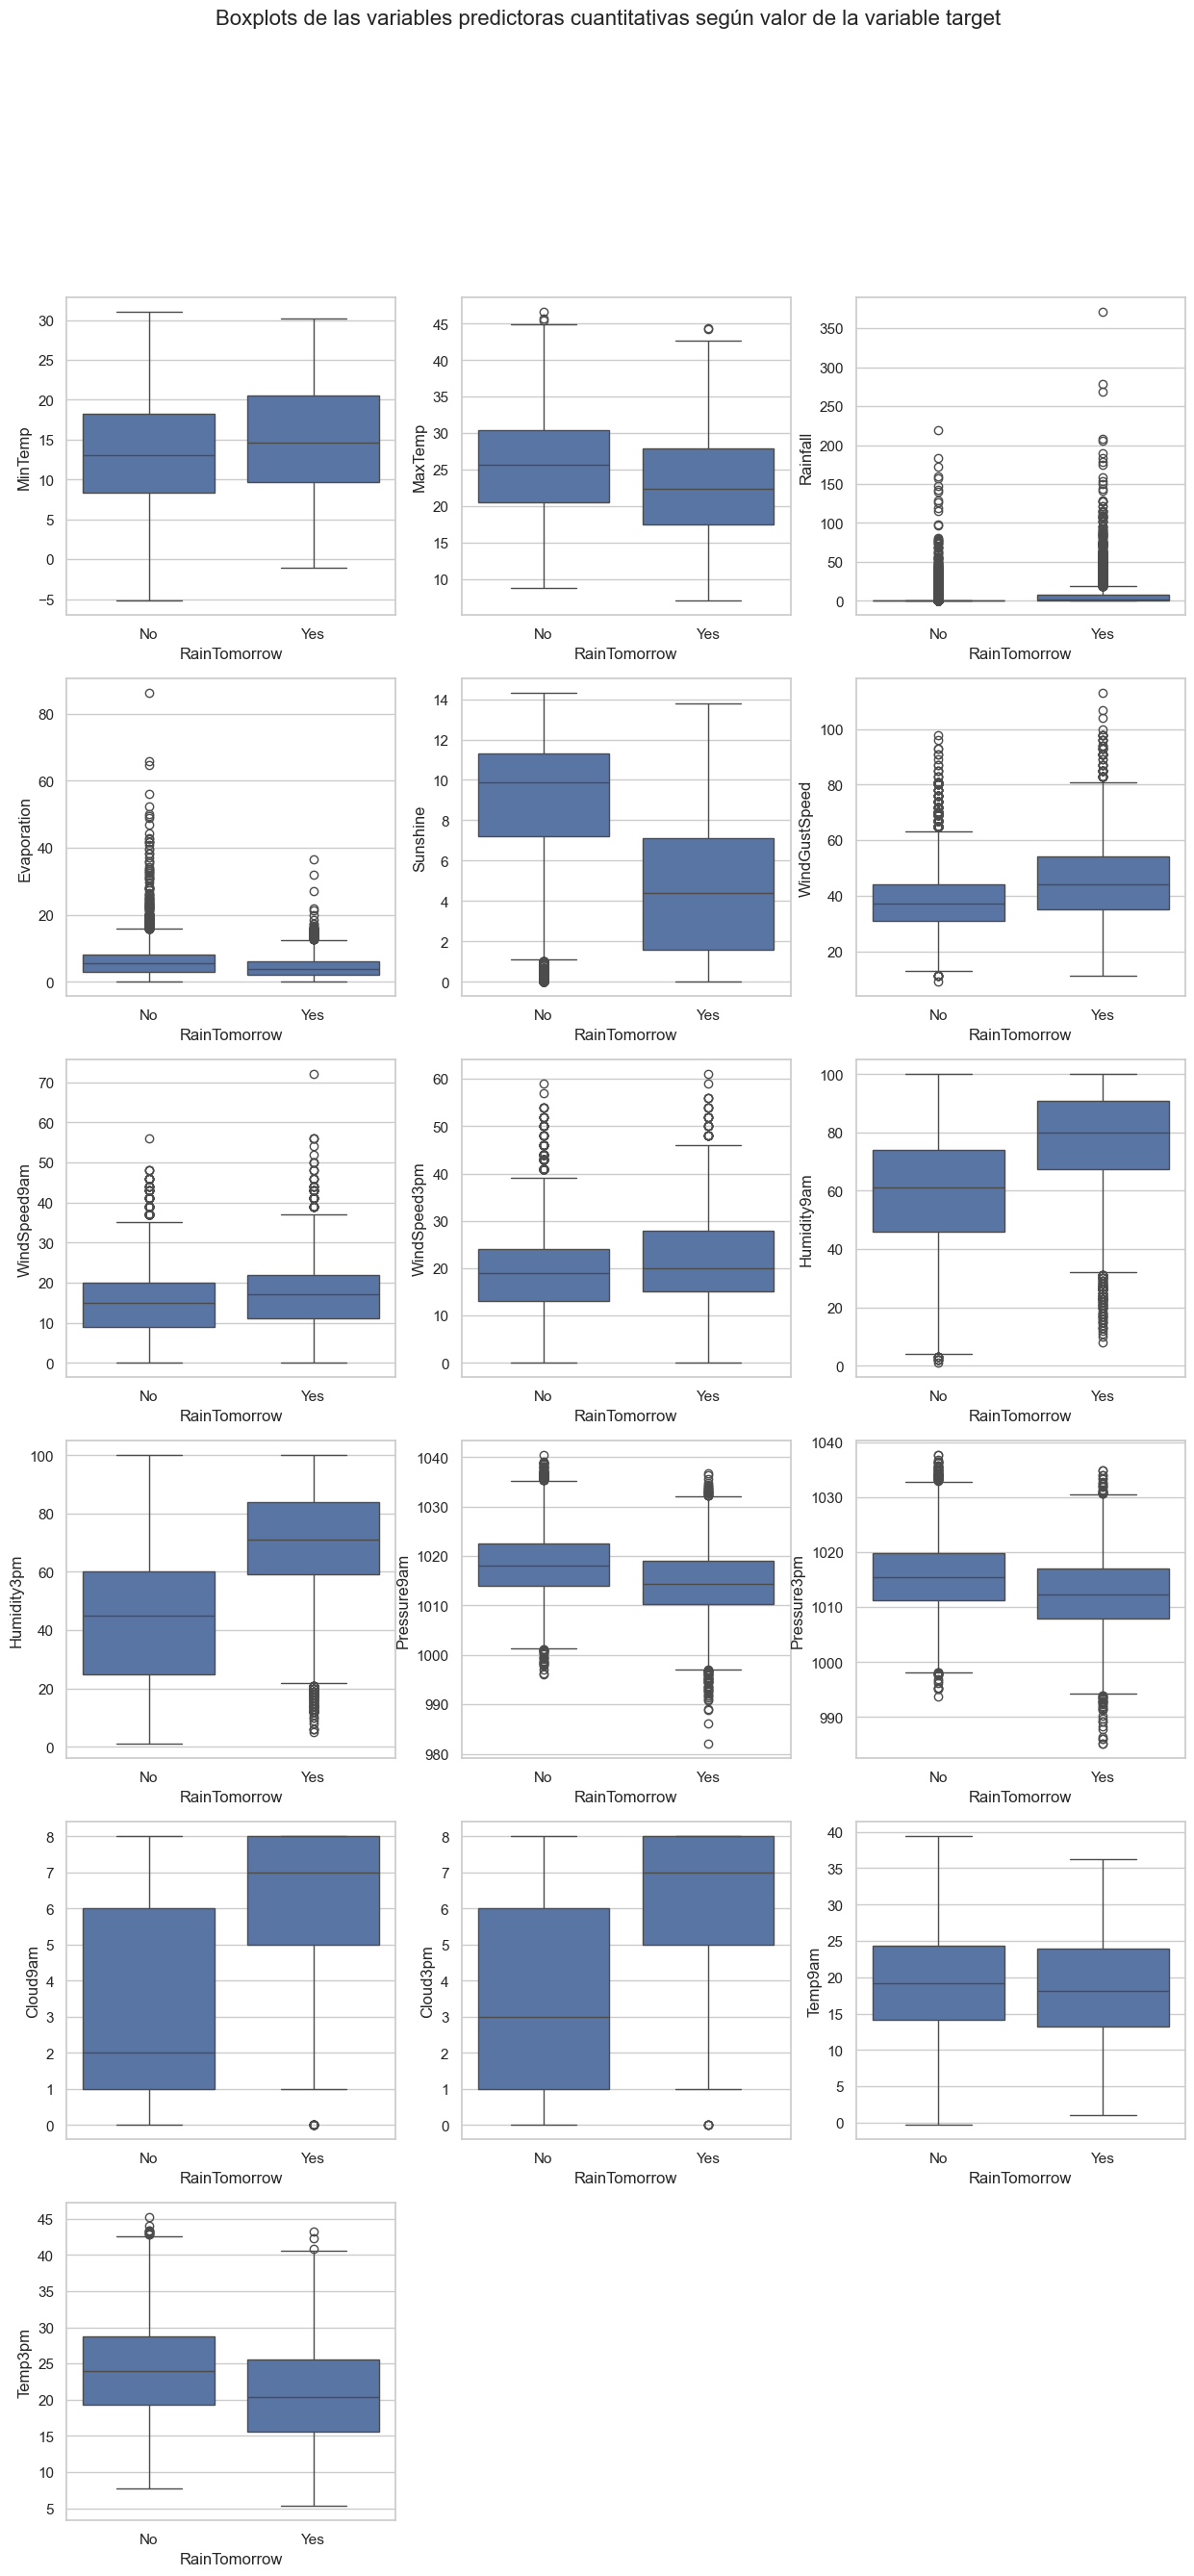

In [214]:
n_features_cuanti = len(features_cuanti)
n_col = 3
n_row = n_features_cuanti//n_col if n_features_cuanti%n_col == 0 else  n_features_cuanti//n_col + 1
fig, axes = plt.subplots(nrows=n_row,ncols=n_col,figsize=(n_col*5,5*n_row))
fig.suptitle('Boxplots de las variables predictoras cuantitativas según valor de la variable target',fontsize=16)
fig.subplots_adjust(hspace=0.2)
for i,feature in enumerate(features_cuanti):
    # Posición de cada boxplot 
    row = i//n_col
    col = i%n_col
    sns.boxplot(data=X_train,x=y_train,y=feature,ax=axes[row, col])
    #axes[row, col].set_title(feature)
    #axes[row, col].set_xlabel('Target')
    #axes[row, col].set_ylabel(feature)

# Eliminar subplots vacíos si es necesario
if n_features_cuanti % n_col != 0:
    for i in range(n_features_cuanti % n_col, n_col):
        fig.delaxes(axes[n_row - 1, i])

plt.show()

ADVERTENCIA: Se observa que las features vinculadas con la nubosidad (sunshine | cloud 9 am | cloud 3 pm)
son muy importante para explicar la variable target, sin embargo, para un alto porcentaje de las observaciones no se dispone de los datos relativos a la nubosidad. 

In [215]:
# Correlación entre variables cualitativas incluyendo la target
df_corr_rain_cuali = pd.DataFrame({
    'RainToday': ['RainToday_Yes','RainToday_Yes','RainToday_No','RainToday_No'],
    'RainTomorrow': ['RainTomorrow_Yes','RainTomorrow_No','RainTomorrow_Yes','RainTomorrow_No'],
    'Frec_abs': [None,None,None,None]
})
df_corr_rain_cuali.loc[0,'Frec_abs'] = len(df_train[(df_train['RainToday']=='Yes') & (df_train['RainTomorrow']=='Yes')])
df_corr_rain_cuali.loc[1,'Frec_abs'] = len(df_train[(df_train['RainToday']=='Yes') & (df_train['RainTomorrow']=='No')])
df_corr_rain_cuali.loc[2,'Frec_abs'] = len(df_train[(df_train['RainToday']=='No') & (df_train['RainTomorrow']=='Yes')])
df_corr_rain_cuali.loc[3,'Frec_abs'] = len(df_train[(df_train['RainToday']=='No') & (df_train['RainTomorrow']=='No')])

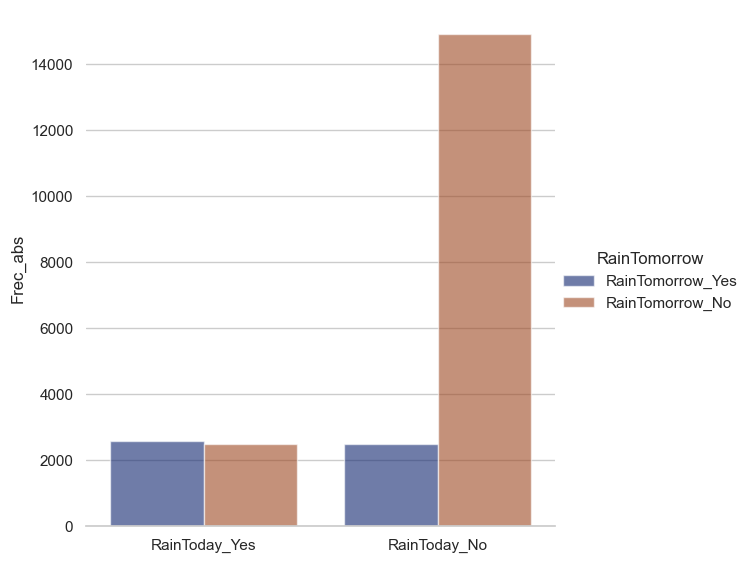

In [216]:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=df_corr_rain_cuali, kind="bar",
    x="RainToday", y="Frec_abs", hue="RainTomorrow",
    errorbar=None, palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "Frec_abs")
g.set_titles('Visualización de correlación entre variables cuantitativas')
plt.show()

Se observa que existe cierto grado de correlación positiva entre esas variables cualitativas

In [217]:
# Obtengo el porcentaje de valores atípicos por feature cuantitativa
serie_porcentaje_atipicos = pd.Series()
for feature in features_cuanti:
    serie = X_train[feature]
    q1 , q3 = serie.quantile(q=[0.25,0.75])
    r_i = q3 - q1
    lim_inf = q1 - 1.5 * r_i
    lim_sup = q3 + 1.5 * r_i
    # En caso que trate atípicos puede ser conveniente la línea de abajo
    #feature_idx_atipicos =  serie[ (serie<lim_inf) | (serie>lim_sup) ].index
    n_atipicos =  serie[ (serie<lim_inf) | (serie>lim_sup) ].count()
    n_no_nan = serie.count()
    porcen_atipicos = round(n_atipicos / n_no_nan * 100,2)  
    serie_porcentaje_atipicos[feature] = porcen_atipicos
serie_porcentaje_atipicos.sort_values(ascending=False) 

Rainfall         19.63
Evaporation       1.88
WindSpeed3pm      1.51
WindGustSpeed     1.30
WindSpeed9am      1.12
Pressure9am       0.80
Pressure3pm       0.60
Humidity9am       0.11
Temp3pm           0.05
MaxTemp           0.01
MinTemp           0.00
Sunshine          0.00
Humidity3pm       0.00
Cloud9am          0.00
Cloud3pm          0.00
Temp9am           0.00
dtype: float64

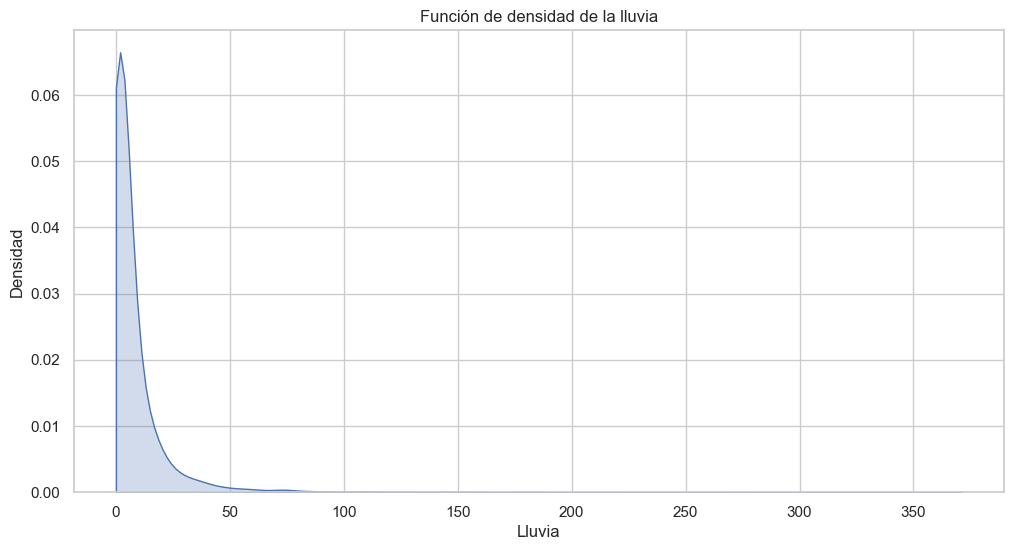

In [218]:
# Se grafica la función de densidad de la feature Rainfall para aquellos días que llovió
s_lluvia = X_train[X_train['Rainfall']>0]['Rainfall']
bandwidth = 1.5
plt.figure(figsize=(12, 6))
sns.kdeplot(data=s_lluvia, fill=True, bw_adjust=bandwidth,cut=0)
plt.title('Función de densidad de la lluvia')
plt.xlabel('Lluvia')
plt.ylabel('Densidad')
current_values = plt.gca().get_xticks()
plt.show()

In [219]:
# Se construye esta tabla para evidenciar la presencia de valores fuertemente atípicos para la variable llvua
rangos_lluvia = pd.cut(s_lluvia,bins=range(0,401,50), right=True)
df_frec_lluvia = rangos_lluvia.value_counts().sort_index().reset_index()
df_frec_lluvia.rename(columns={'Rainfall':'Rainfall','count':'Frecuencia_absoluta'},inplace=True)
df_frec_lluvia.set_index('Rainfall',inplace=True)
df_frec_lluvia['Frecuencia_relativa'] = round(df_frec_lluvia['Frecuencia_absoluta'] / df_frec_lluvia['Frecuencia_absoluta'].sum(),2)
df_frec_lluvia['Frecuencia_absoluta_acumulada'] = df_frec_lluvia['Frecuencia_absoluta'].cumsum()
df_frec_lluvia['Frecuencia_relativa_acumulada'] = df_frec_lluvia['Frecuencia_relativa'].cumsum()
df_frec_lluvia

,Frecuencia_absoluta,Frecuencia_relativa,Frecuencia_absoluta_acumulada,Frecuencia_relativa_acumulada
Rainfall,,,,
"(0, 50]",7418,0.98,7418,0.98
"(50, 100]",117,0.02,7535,1.00
"(100, 150]",31,0.00,7566,1.00
"(150, 200]",11,0.00,7577,1.00
"(200, 250]",3,0.00,7580,1.00
"(250, 300]",2,0.00,7582,1.00
"(300, 350]",0,0.00,7582,1.00
"(350, 400]",1,0.00,7583,1.00


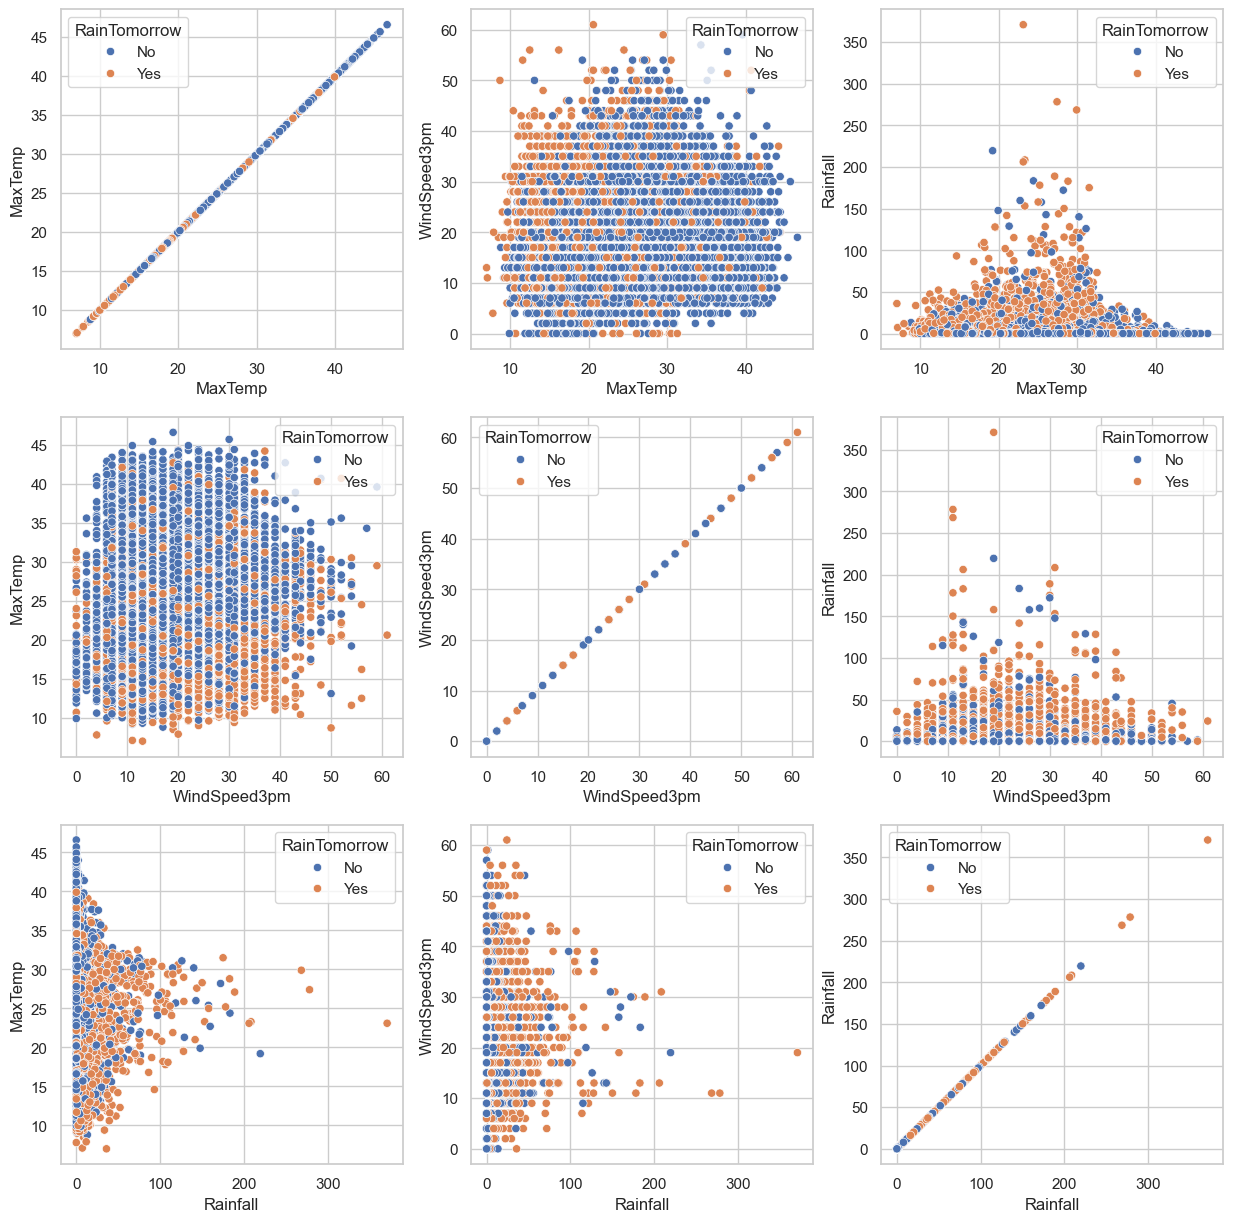

In [220]:
# Por la imposiblidad de ver todos los scatter plot posibles entre cuantitativas, se eligen
#3 features
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
columns = ['MaxTemp','WindSpeed3pm','Rainfall']
fig.subplots_adjust(hspace=0.2)
i = 0
for col in columns:
    j = 0
    for col2 in columns:
        #agregamos labels para usarlas luego
        sns.scatterplot(data=df_train, x=col, y=col2, hue="RainTomorrow",ax=axs[i,j]) 
        j+=1
    i+=1
plt.show()

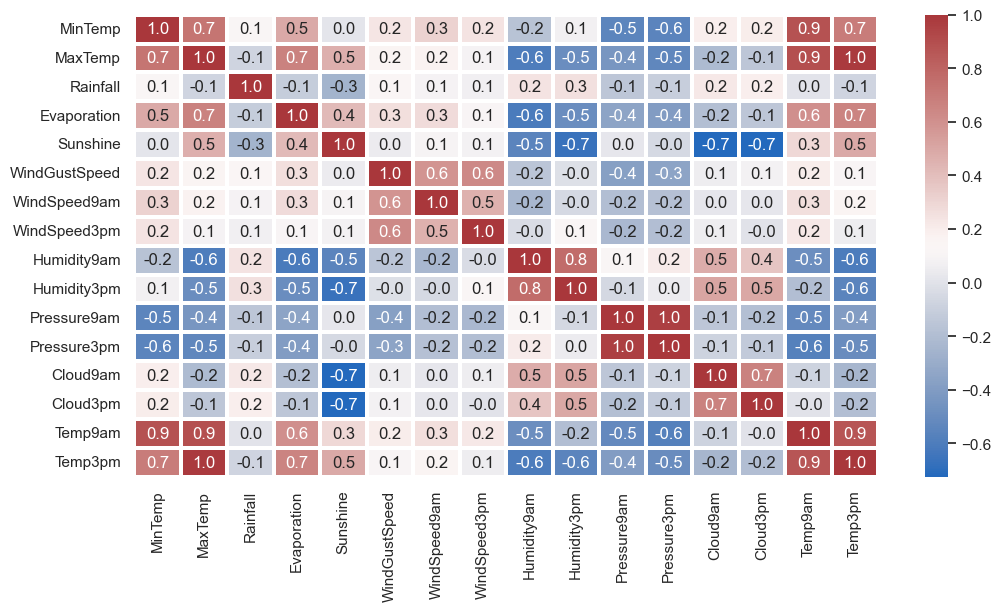

In [221]:
plt.figure(figsize=(12, 6))
sns.heatmap(data=df_train[features_cuanti].corr(),annot=True,fmt=".1f",linewidths=1.5,cmap='vlag')
plt.show()

La colinealidad es un rango entre las features. Por un lado, se observa una correlación lineal positiva fuerte entre variables meteorológicas que únicamente difieren en la hora del día en el que fueron registradas. Por el otro, se verifica una correlación negativa de gran intensidad entre variables que naturalmente tienen comportamientos opuestos como la feature sunshine y las features vinculadas con la medición de la nubosidad.

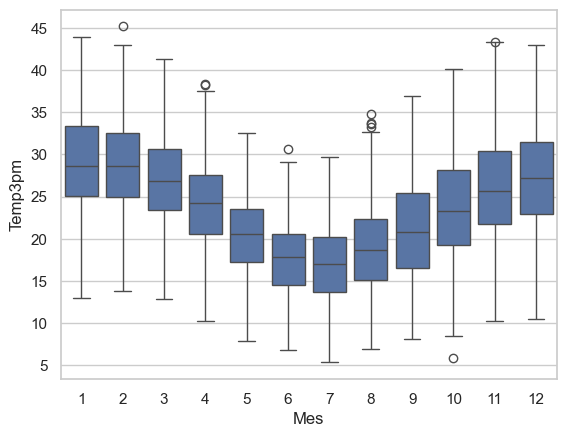

In [227]:
sns.boxplot(data=df_train,y='Temp3pm',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

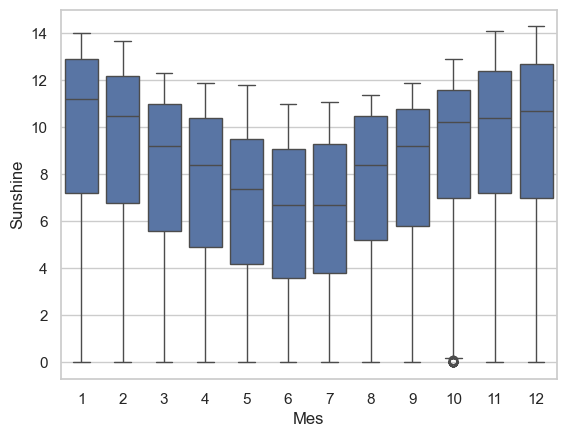

In [228]:
sns.boxplot(data=df_train,y='Sunshine',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

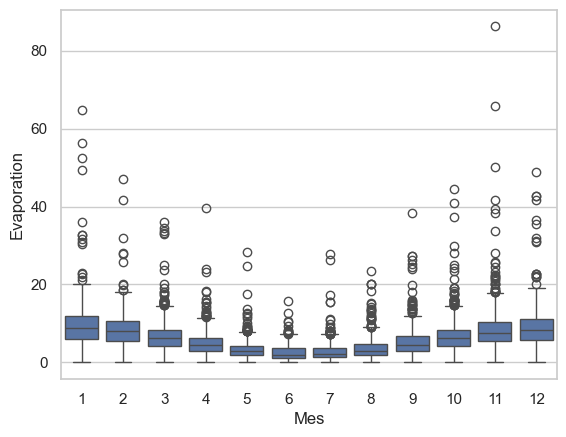

In [229]:
sns.boxplot(data=df_train,y='Evaporation',x=df_train['Date'].dt.month)
plt.xlabel('Mes')
plt.show()

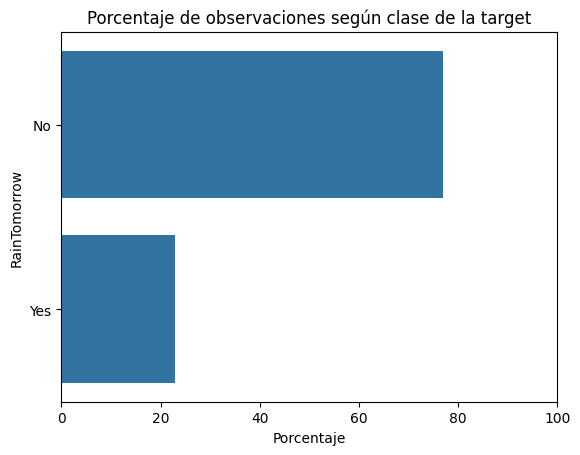

In [106]:
# Análisis de balanceo del df de entrenamiento
balanceo = round(y_train.value_counts() / len(y_train) *100,0)
sns.barplot(balanceo,orient='y')
plt.ylabel('RainTomorrow')
plt.xlabel('Porcentaje')
plt.xlim((0,100))
plt.title('Porcentaje de observaciones según clase de la target')
plt.show()

In [104]:
balanceo

RainTomorrow
No     77.0
Yes    23.0
Name: count, dtype: float64

El dataframe de entrenamiento no está balanceado debido a que más del 75% de las observaciones totales pertenecen a la variable target negativa.

In [34]:
# Tratamiento de faltantes en features con una alta proporción de valores faltantes
X_train_media_seg_sunshine_by_mes = X_train.groupby(X_train['Date'].dt.month)['Sunshine'].transform('mean')
X_train_media_seg_cloud9am_by_mes = X_train.groupby(X_train['Date'].dt.month)['Cloud9am'].transform('mean')
X_train_media_seg_cloud3pm_by_mes = X_train.groupby(X_train['Date'].dt.month)['Cloud3pm'].transform('mean')
X_train_media_seg_evaporation_by_mes = X_train.groupby(X_train['Date'].dt.month)['Evaporation'].transform('mean')
X_train_imputed = X_train.fillna({
    'Sunshine': X_train_media_seg_sunshine_by_mes,
    'Cloud9am': X_train_media_seg_cloud9am_by_mes,
    'Cloud3pm': X_train_media_seg_cloud3pm_by_mes,
    'Evaporation': X_train_media_seg_evaporation_by_mes,
})
X_test_imputed = X_test.fillna({
    'Sunshine': X_train_media_seg_sunshine_by_mes,
    'Cloud9am': X_train_media_seg_cloud9am_by_mes,
    'Cloud3pm': X_train_media_seg_cloud3pm_by_mes,
    'Evaporation': X_train_media_seg_evaporation_by_mes,
})

In [35]:
# Tratamiento de faltantes en features cualitativas
X_train_moda_dir_nudo_viento = X_train['WindGustDir'].mode()[0]
X_train_moda_dir_viento9am = X_train['WindDir9am'].mode()[0]
X_train_moda_dir_viento3pm = X_train['WindDir3pm'].mode()[0]
X_train_moda_raintoday = X_train['RainToday'].mode()[0]
X_train_imputed = X_train_imputed.fillna({
    'WindGustDir': X_train_moda_dir_nudo_viento,
    'WindDir9am': X_train_moda_dir_nudo_viento,
    'WindDir3pm': X_train_moda_dir_nudo_viento,
    'RainToday': X_train_moda_raintoday
})
X_test_imputed = X_test_imputed.fillna({
    'WindGustDir': X_train_moda_dir_nudo_viento,
    'WindDir9am': X_train_moda_dir_nudo_viento,
    'WindDir3pm': X_train_moda_dir_nudo_viento,
    'RainToday': X_train_moda_raintoday
})

In [38]:
def codificar_features_cuanti(data_set,col_catego):
    """Recibe un data frame y sus columnas categoricas y 
    devuelve el data frame transformado con la correspondiente 
    codificación de estas columnas"""
    encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoded = encoder.fit_transform(data_set[col_catego])
    one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(col_catego))
    df_encoded = pd.concat([data_set, one_hot_df], axis=1)
    df_encoded = df_encoded.drop(col_catego, axis=1)
    return df_encoded


In [39]:
#Codificación de features categóricas
X_train_encoded_imputed = codificar_features_cuanti(X_train_imputed,features_cuali)
X_test_encoded_imputed = codificar_features_cuanti(X_test_imputed,features_cuali)

In [40]:
print("X_train_imputed\n",X_train_imputed.head(5))
print("X_train_encoded_imputed\n",X_train_encoded_imputed.head(5))

X_train_imputed
         Date  MinTemp  MaxTemp  Rainfall  Evaporation   Sunshine WindGustDir  \
0 2016-06-01     11.9     23.2       0.0          2.6   6.145902           E   
1 2009-10-13      8.9     20.7       0.0          4.2   8.500000           W   
2 2009-02-28     22.2     36.9       0.0          9.4  12.000000           W   
3 2014-09-12      8.7     21.9       0.0          6.2   7.965803           S   
4 2016-01-22     16.5     30.4       0.0          8.2  13.100000           E   

   WindGustSpeed WindDir9am WindDir3pm  ...  WindSpeed3pm  Humidity9am  \
0           30.0          E          E  ...          19.0         77.0   
1           41.0          S          W  ...          28.0         61.0   
2           41.0          N          W  ...          19.0         41.0   
3           33.0          E          S  ...          13.0         39.0   
4           39.0          E          S  ...          28.0         46.0   

   Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud

In [41]:
# Tratamiento de valores atípicos para la feature Rainfall
# La lluvia presenta una significatía asimetría positiva. Para evitar distorsiones sobre el valor de los 
# parámetros del modelo, se imputan los valores atípicos de esta variable en base al mayor valor típico observado 
# para la variable en cuestión.
s_lluvia = X_train_encoded_imputed[X_train_encoded_imputed['Rainfall']>0]['Rainfall']
q1 , q3 = s_lluvia.quantile(q=[0.25,0.75])
r_i = q3 - q1
valor_tipico_sup = q3 + 1.5 * r_i
# Imputacion para train
X_train_encoded_imputed_idx_lluvia_ati = X_train_encoded_imputed[X_train_encoded_imputed['Rainfall']>valor_tipico_sup].index
X_train_encoded_imputed.loc[X_train_encoded_imputed_idx_lluvia_ati,'Rainfall'] = valor_tipico_sup
# Imputacion para test
X_test_encoded_imputed_idx_lluvia_ati = X_test_encoded_imputed[X_test_encoded_imputed['Rainfall']>valor_tipico_sup].index
X_test_encoded_imputed.loc[X_test_encoded_imputed_idx_lluvia_ati,'Rainfall'] = valor_tipico_sup


In [42]:
X_train_encoded_imputed.isna().sum()

Date               0
MinTemp           35
MaxTemp           21
Rainfall         141
Evaporation        0
Sunshine           0
WindGustSpeed    515
WindSpeed9am     298
WindSpeed3pm     291
Humidity9am      283
Humidity3pm      286
Pressure9am      258
Pressure3pm      258
Cloud9am           0
Cloud3pm           0
Temp9am           17
Temp3pm           21
WindGustDir_E      0
WindGustDir_N      0
WindGustDir_S      0
WindGustDir_W      0
WindDir9am_E       0
WindDir9am_N       0
WindDir9am_S       0
WindDir9am_W       0
WindDir3pm_E       0
WindDir3pm_N       0
WindDir3pm_S       0
WindDir3pm_W       0
RainToday_No       0
RainToday_Yes      0
dtype: int64

In [43]:
# Tratamiento de faltantes en el resto de las features no paso df entero para evitar problmeas con col date
imputer = SimpleImputer(strategy='mean')  # Utilizando la media para imputar los valores faltantes
X_train_encoded_imputed[features_cuanti] = pd.DataFrame(imputer.fit_transform(X_train_encoded_imputed[features_cuanti]))
X_test_encoded_imputed[features_cuanti] = pd.DataFrame(imputer.transform(X_test_encoded_imputed[features_cuanti]))

In [45]:
# Escalado de datos - falta escalado de variables cuantitativas
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_encoded_imputed[features_cuanti]), columns=features_cuanti)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_encoded_imputed[features_cuanti]), columns=features_cuanti)

In [46]:
X_train_scaled

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
0,-0.268352,-0.261735,-0.416803,-0.856885,-0.631415,-0.860427,-1.023469,-0.062200,0.611589,0.498342,0.523238,5.345024e-01,0.197169,0.155456,-0.251661,-0.155630
1,-0.738715,-0.622967,-0.416803,-0.431282,0.183702,0.073276,0.572822,1.048343,-0.119267,-0.156239,1.270185,1.205441e+00,1.408279,-1.454511,-0.571015,-0.582654
2,1.346561,1.717817,-0.416803,0.951929,1.395592,0.073276,0.204447,-0.062200,-1.032837,-1.378125,-1.001142,-1.036105e+00,0.958662,-0.974461,1.025758,1.817518
3,-0.770073,-0.449575,-0.416803,0.100722,-0.001266,-0.605781,-0.286720,-0.802562,-1.124194,-1.116292,0.000000,-1.733566e-14,-1.739043,-1.934561,-0.373320,-0.332329
4,0.452871,0.778614,-0.416803,0.632726,1.776471,-0.096488,1.063989,1.048343,-0.804444,-0.505349,0.111655,-1.444756e-02,-1.289425,-1.454511,0.493500,0.683694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22582,0.358799,-0.319532,-0.416803,0.100722,-0.578058,-0.266252,0.450030,-0.062200,-0.210624,-0.243517,-0.071270,-6.019340e-02,1.408279,-0.014360,-0.130002,-0.494304
22583,-0.597607,-1.735561,3.318522,-1.388889,-2.413206,-0.436017,-1.883011,-0.308988,1.662194,1.502034,0.096412,7.327344e-01,0.197169,0.155456,-1.361798,-1.657578
22584,-0.848467,-1.345431,1.381687,0.241796,0.323868,0.497686,-0.041136,0.061193,0.200482,0.585620,0.447019,1.068204e+00,-0.150229,-0.211867,-1.133688,-1.436703
22585,-1.993017,-1.215387,-0.416803,-1.016486,-0.993563,-1.199955,-1.883011,-1.542924,0.000000,0.000000,-0.193221,-5.329003e-01,-0.171434,-0.228720,-2.198203,-1.112753


In [47]:
target_dict = {
    'No':0,
    'Yes':1
}

In [48]:
# Codificación de la target
y_train_encoded = y_train.map(target_dict)
y_test_encoded = y_test.map(target_dict)